# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

### 5. Dni z przekroczeniem normy według województwa
Wygeneruj wykres pokazujący liczbę dni z przekroczeniem normy stężenia PM2.5 (średnie dzienne stężenie) grupując dane po województwach. Dodaj opis do uzyskanych wyników.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from read_and_clean_data import (
    download_gios_archive, 
    download_metadata, 
    clean_data,
    get_common_stations,
    save_cleaned_data
)

from data_analysis import (
    load_data,
    calculate_daily_stats,
    calculate_monthly_stats,
    merge_stats,
    save_to_csv
)

from visualizations import (
    plot_monthly_trends,
    heatmaps,
    days_over_norm,
    days_over_norm_by_voivodeship
)

Pobieranie i czyszczenie danych

In [3]:
# URL-e do pobierania danych
GIOS_ARCHIVE_URL = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
METADATA_URL = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/622"

# Słownik konfiguracyjny
YEAR_CONFIG = {
    2015: {
        'archive_id': '236',
        'pm25_filename': '2015_PM25_1g.xlsx'
    },
    2018: {
        'archive_id': '603',
        'pm25_filename': '2018_PM25_1g.xlsx'
    },
    2021: {
        'archive_id': '486',
        'pm25_filename': '2021_PM25_1g.xlsx'
    },
    2024: {
        'archive_id': '582',
        'pm25_filename': '2024_PM25_1g.xlsx'
    }
}

In [4]:
def download_and_clean(years_to_process=None):
    """Główna funkcja wykonująca cały proces pobierania i czyszczenia danych."""
    print("=== Rozpoczynanie procesu pobierania i czyszczenia danych PM2.5 ===")
    
    # Jeśli nie podano lat, użyj wszystkich z konfiguracji
    if years_to_process is None:
        years_to_process = list(YEAR_CONFIG.keys())
    
    # Pobieranie metadanych
    df_metadata = download_metadata(METADATA_URL)
    if df_metadata is None:
        print("Nie udało się pobrać metadanych.")
        return None
    
    # Pobieranie i czyszczenie danych dla każdego roku
    print(f"\nPrzetwarzanie lat: {years_to_process}")
    cleaned_data_dict = {}
    
    for year in years_to_process:
        if year not in YEAR_CONFIG:
            print(f"Ostrzeżenie: Brak konfiguracji dla roku {year}.")
            continue
        
        print(f"\nPrzetwarzanie roku {year}")
        
        # Pobierz dane
        df_raw = download_gios_archive(year, YEAR_CONFIG[year], GIOS_ARCHIVE_URL)
        if df_raw is None:
            print(f"Nie udało się pobrać danych dla roku {year}.")
            continue
        
        # Oczyść dane
        try:
            df_clean = clean_data(df_raw, year, df_metadata)
            cleaned_data_dict[year] = df_clean
        except Exception as e:
            print(f"Błąd podczas czyszczenia danych dla roku {year}: {e}")
            continue
    
    # Sprawdź czy mamy dane do połączenia
    if not cleaned_data_dict:
        print("Brak danych do połączenia. Kończenie pracy.")
        return None
    
    # Znajdź wspólne stacje
    common_stations = get_common_stations(cleaned_data_dict)
    
    # Połącz dane z wszystkich lat
    all_data_frames = list(cleaned_data_dict.values())
    df_all = pd.concat(all_data_frames, ignore_index=True)
    
    # Filtruj tylko wspólne stacje
    if common_stations:
        initial_count = len(df_all)
        df_all = df_all[df_all['kod_stacji'].isin(common_stations)]
        filtered_count = initial_count - len(df_all)
        print(f"Usunięto {filtered_count} pomiarów z nie-wspólnych stacji")
    
    # Zapis do pliku
    output_file = save_cleaned_data(df_all)
    
    # Podsumowanie
    print("\n=== PODSUMOWANIE ===")
    print(f"Przetworzone lata: {list(cleaned_data_dict.keys())}")
    print(f"Liczba wspólnych stacji: {len(common_stations)}")
    print(f"Całkowita liczba pomiarów: {df_all.shape[0]}")
    print(f"Zakres dat: {df_all['data'].min().date()} - {df_all['data'].max().date()}")
    print(f"Plik wynikowy: {output_file}")
    
    # Przykładowe dane
    print("\nPrzykładowe dane:")
    print(df_all.head())
    
    return df_all, df_metadata

In [5]:
# Uruchomienie głównej funkcji
cleaned_df, df_metadata = download_and_clean(years_to_process=[2015, 2018, 2021, 2024])

=== Rozpoczynanie procesu pobierania i czyszczenia danych PM2.5 ===
Metadane pobrane pomyślnie: 1134 wierszy, 15 kolumn

Przetwarzanie lat: [2015, 2018, 2021, 2024]

Przetwarzanie roku 2015
Dane dla roku 2015 pobrane pomyślnie
Po filtracji: 8761 wierszy (usunięto 2)
Rok 2015: Utworzono mapowanie dla 302 starych kodów stacji
367920 pomiarów, 365 dni, 42 stacji

Przetwarzanie roku 2018
Dane dla roku 2018 pobrane pomyślnie
Po filtracji: 8762 wierszy (usunięto 4)
Rok 2018: Utworzono mapowanie dla 302 starych kodów stacji
446760 pomiarów, 365 dni, 51 stacji

Przetwarzanie roku 2021
Dane dla roku 2021 pobrane pomyślnie
Po filtracji: 8761 wierszy (usunięto 5)
Rok 2021: Utworzono mapowanie dla 302 starych kodów stacji
770880 pomiarów, 365 dni, 88 stacji

Przetwarzanie roku 2024
Dane dla roku 2024 pobrane pomyślnie
Po filtracji: 8785 wierszy (usunięto 5)
Rok 2024: Utworzono mapowanie dla 302 starych kodów stacji
Ostrzeżenie rok 2024: Brak miejscowości dla 1 stacji ['LuLubsStrzelMOB']
843264 pom

Liczenie średnich i wskazywanie dni z przekroczeniem normy

In [6]:
def calculate_statistics():
    """Oblicza statystyki dobowe i miesięczne oraz łączy je z danymi."""
    df = load_data('pm25_cleaned.csv')

    daily = calculate_daily_stats(df)
    monthly = calculate_monthly_stats(df)

    df_updated = merge_stats(df, daily, monthly)

    save_to_csv(df_updated)

    print("Statystyki zostały obliczone i zapisane")
    print(f"Dodano {len(df_updated.columns) - len(df.columns)} kolumny z nowymi statystykami")
    
    return df_updated

In [7]:
# Uruchomienie funkcji obliczającej statystyki
df_with_stats = calculate_statistics()

Statystyki zostały obliczone i zapisane
Dodano 3 kolumny z nowymi statystykami


Wizualizacje

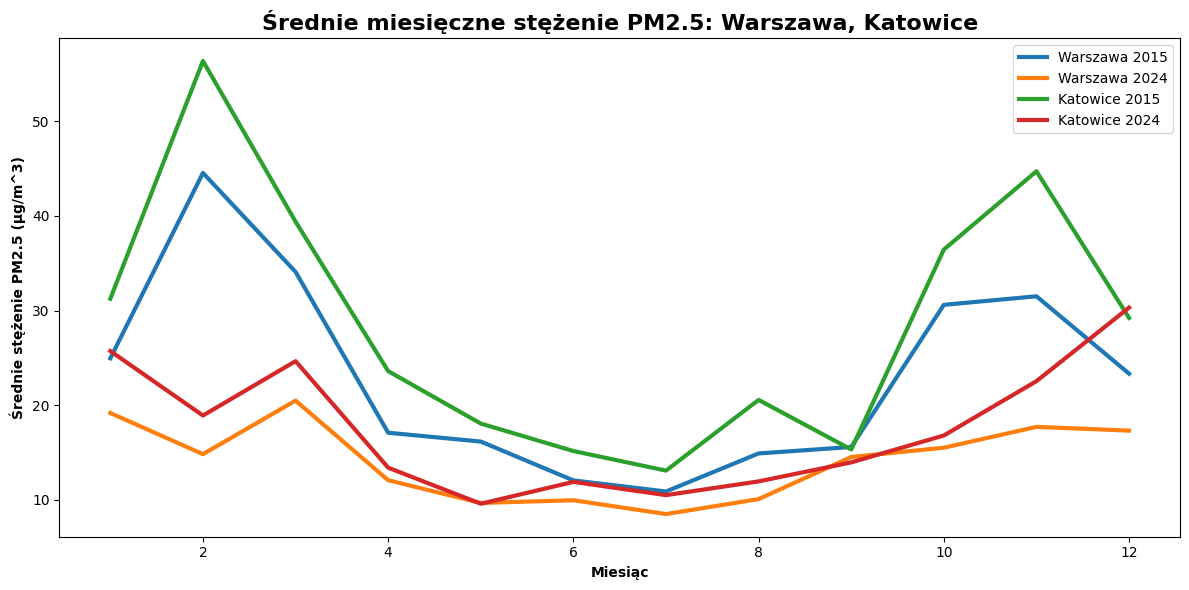

In [8]:
# Wykres trendów miesięcznych dla wybranych miast i lat
plot_monthly_trends(df_with_stats)

Wykres dla lat 2015 i 2024 jest bardzo podobny do poprzedniego wykresy dla lat 2014 oraz 2024, dlatego wnioski pozostają niezmienione. 

Na wykresie wyraźnie widoczna jest sezonowość zanieczyszczenia powietrza, z charakterystycznymi wzrostami stężeń PM2.5 w miesiącach zimowych (wrzesień-marzec). Bezpośrednio wiąże się to ze zwiększonym zapotrzebowaniem na ogrzewanie budynków i dominacją tzw. "niskiej emisji" (emisja z niskich kominów - domów jednorodzinnych, kamienic) z indywidualnych systemów grzewczych, w których często spalane są paliwa stałe (głównie węgiel), a niekiedy nawet odpady.

Różnice obserwowane między rokiem 2015 a 2024 są znaczące i mogą stanowić pozytywny sygnał poprawy jakości powietrza. Trend spadkowy prawdopodobnie odzwierciedla efekty wieloletnich działań naprawczych, w tym krajowych i lokalnych programów dotacyjnych, takich jak "Czyste Powietrze", które finansują wymianę przestarzałych pieców na ekologiczne źródła ciepła. Zaobserwowaną poprawę można również łączyć z rosnącą świadomością ekologiczną społeczeństwa. Warto również zauważyć, że różnice między miastami mogą wynikać z ich specyfiki - podczas gdy Warszawa zmaga się głównie z emisjami komunikacyjnymi, Katowice pozostają pod wpływem historycznego obciążenia przemysłem i strukturą zabudowy.

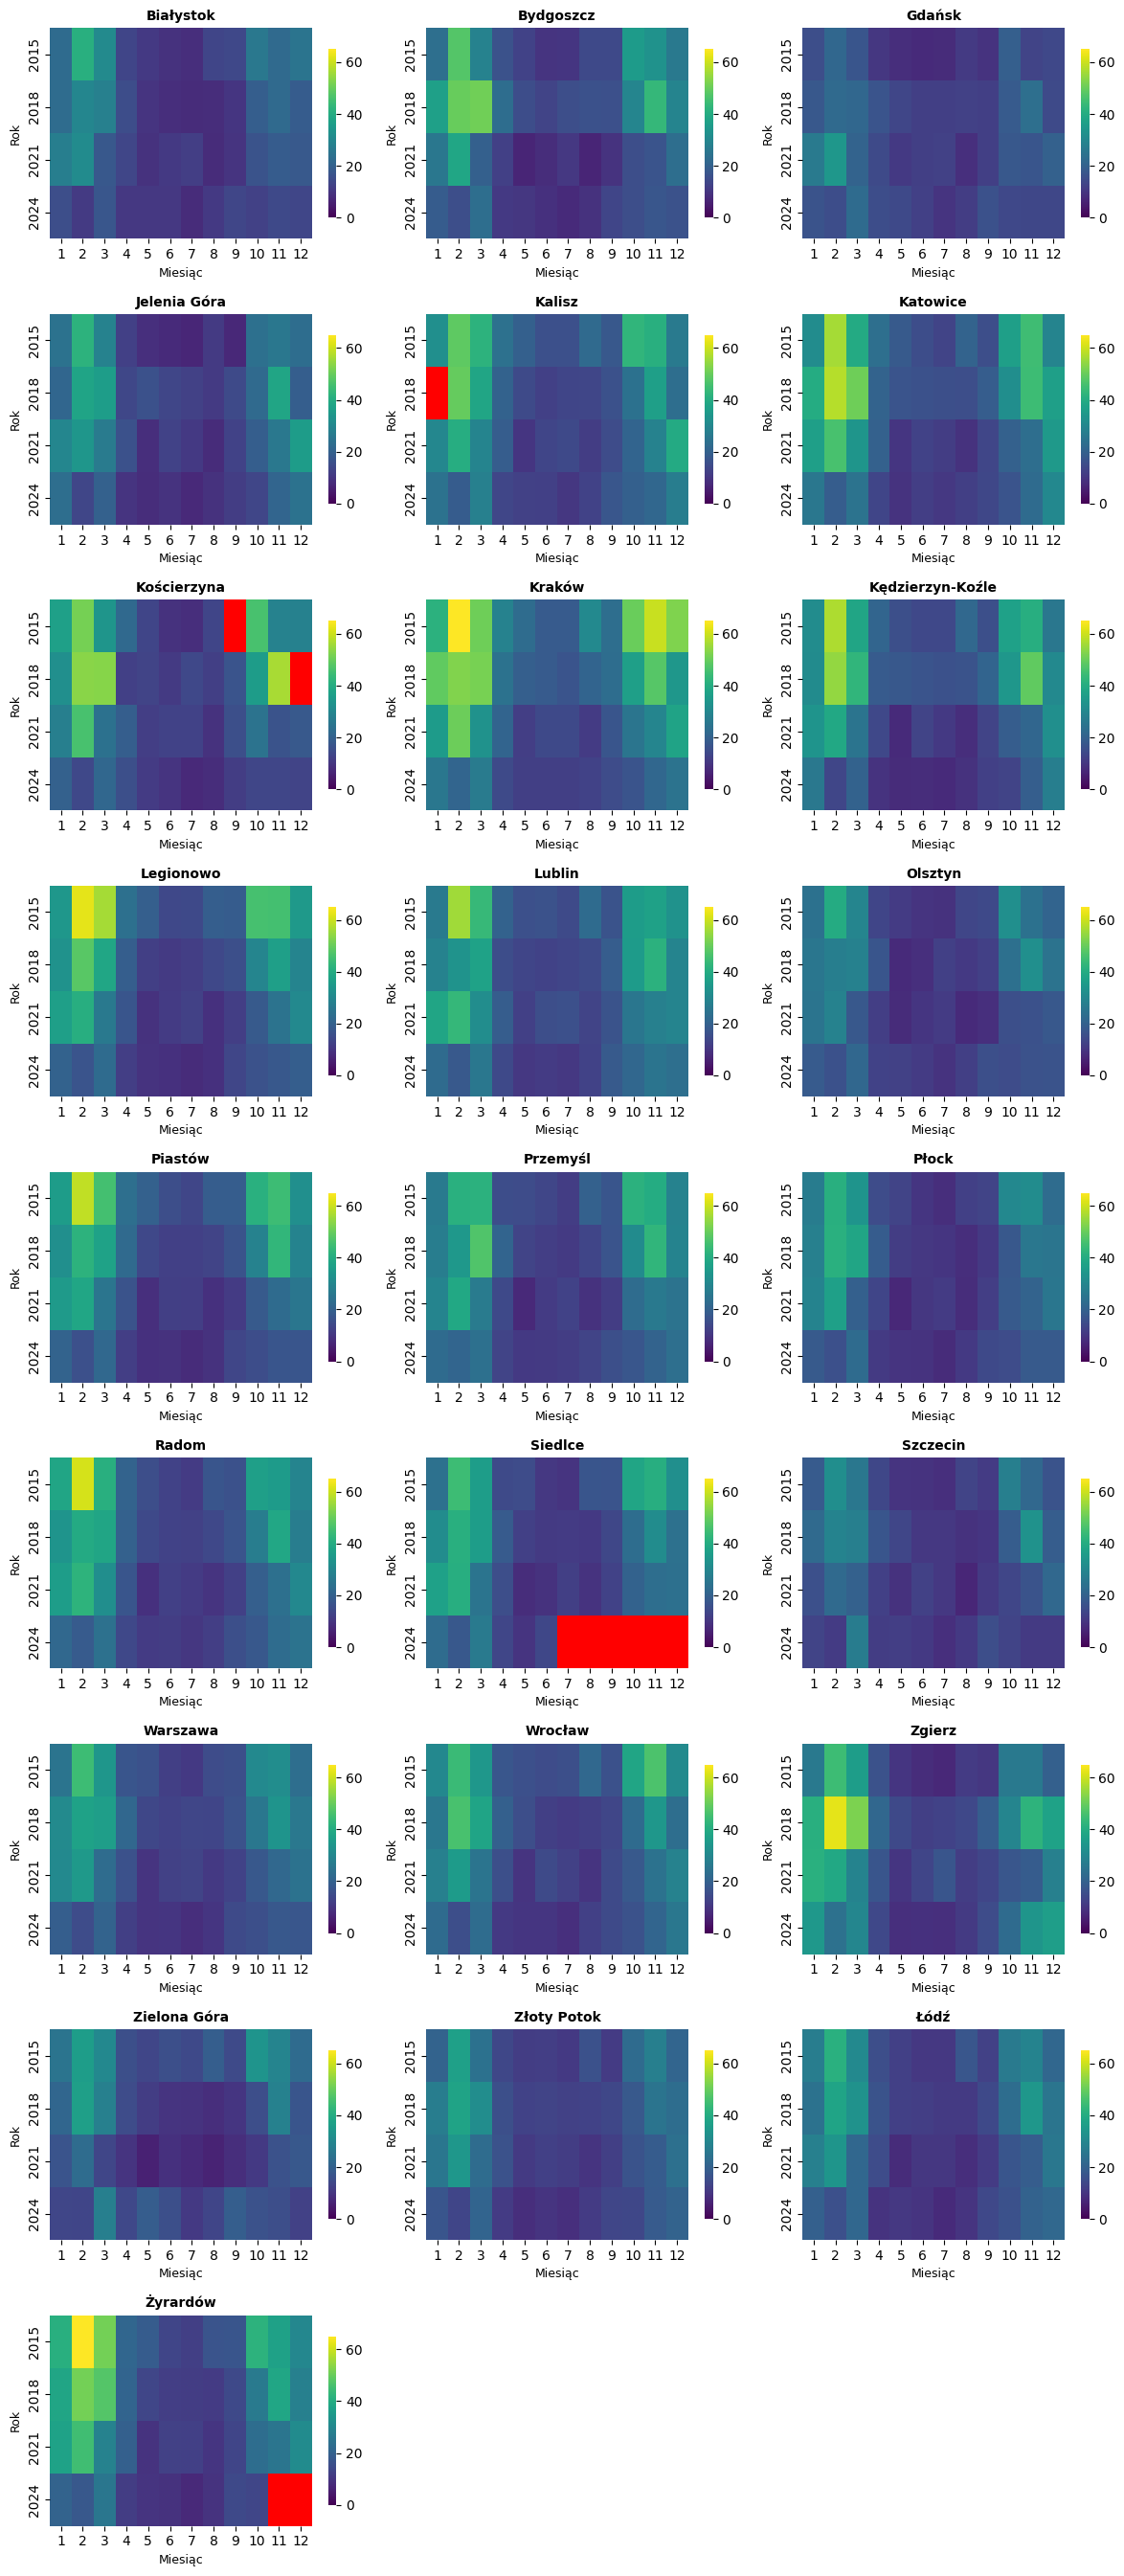

In [9]:
# Heatmapy średnich miesięcznych dla wybranych miast i lat
heatmaps(df_with_stats)

Maksymalne wartości zanieczyszczenia znacząco różnią się w zależności od miasta. Najwyższe miesięczne wartości notowano zazwyczaj w 2015 roku.

W przeważajacej części miast w miesiącach zimowych, gdzie występuje największe zanieczyszczenie, sytuacja poprawiła się na przestrzeni lat. Jednak tempo zmian jest różne w zależności od miasta. Np. w grudniu w Katowicach, Lublinie czy Przemyślu  notowano jednakowe zanieczyszczenie na przestrzeni lat.  

Top 3 stacje z największą liczbą dni powyżej normy (2024):
      kod_stacji Miejscowość   rok  dni_powyzej_normy
31  LdZgieMielcz      Zgierz  2024               5536
39  MpKrakAlKras      Kraków  2024               5272
23  LbLubObywate      Lublin  2024               5080

Bottom 3 stacje z najmniejszą liczbą dni powyżej normy (2024):
       kod_stacji Miejscowość   rok  dni_powyzej_normy
115  ZpSzczAndrze    Szczecin  2024               2728
83   PdBialUpalna   Białystok  2024               2872
63   MzSiedKonars     Siedlce  2024               2896


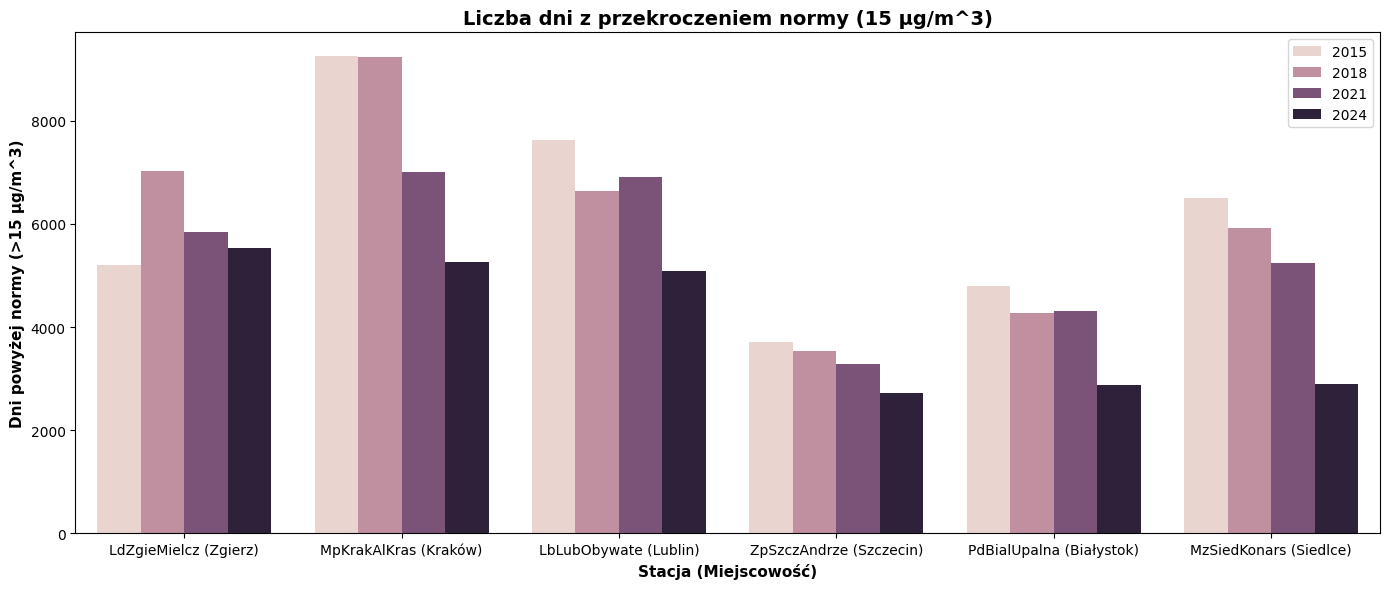

In [14]:
# Wykres słupkowy dni z przekroczeniem normy PM2.5
days_over_norm(df_with_stats)

Trend występowania zanieczyszczeń we wszystkich stacjach jest malejący. Siedlce są szczególnym przypadkiem, poniewaz dla roku 2024 brakuje danych dla połowy miesięcy, stąd tak silny spadek w porównaniu do poprzednich lat.

Wśród sześciu badanych stacji jedynie LdZgieMielcz (Zgierz) nie utrzymuje trendu spadkowego od 2015 roku. Rokiem z największą ilością dni powyżej normy był tam rok 2018.

W ogólności można powiedzieć, że dane wskazują na poprawę sytuacji względem 2015 roku. W większości przypadków nawet w stacjach z największą liczbą dni powyżej normy w 2024 roku, ich liczba jest mniejsza niż notowana w 2015 roku w obecnie "najczystrzych" stacjach.

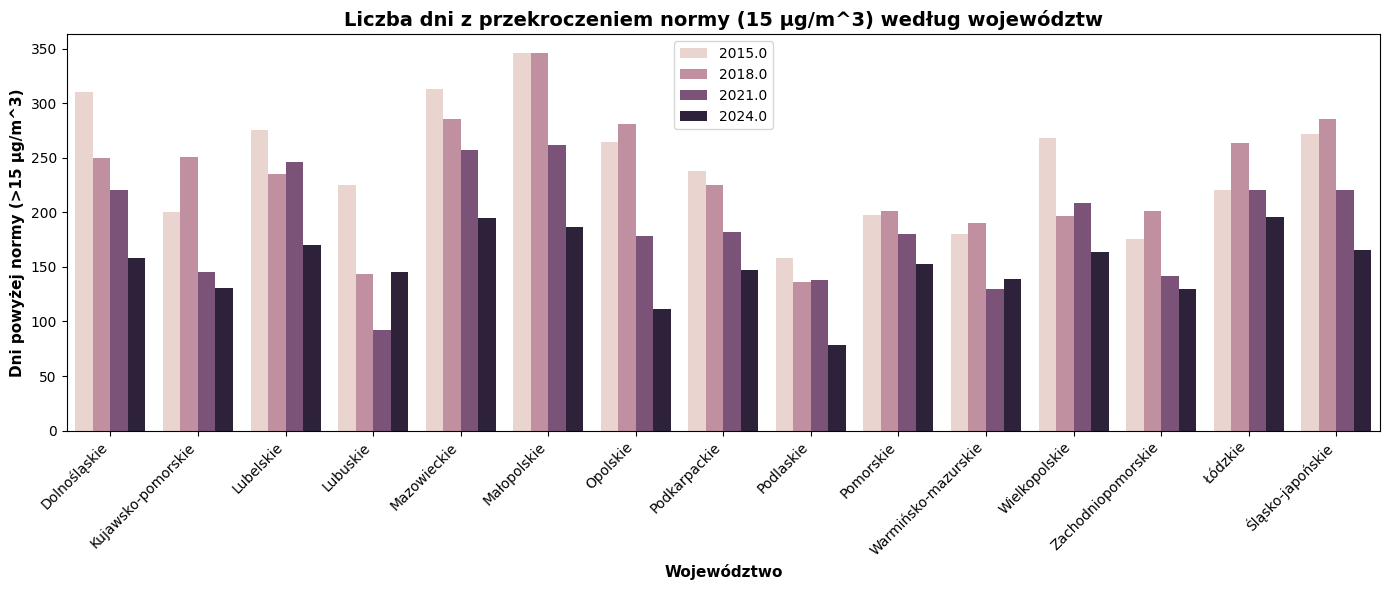

In [12]:
days_over_norm_by_voivodeship(df_with_stats, df_metadata)

Wykres liczby dni z przekroczeniem normy per województwo, podobnie jak poprzednie wykresy, pokazuje poprawę jakości powietrza dla niemal wszystkich polskich województw. Wyjątkiem są tutaj województwa lubuskie i warmińsko-mazurskie, które wykazują wzrost dni z przekroczeniem normy w roku 2024 względem roku 2021 (choć w przypadku województwa warmińsko-mazurskiego jest on nieznaczny).